# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import os
import pathlib
import itertools
import random
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# import own module that cleans data dictionary file
import Data_dict_import

# magic word for producing visualizations in notebook
%matplotlib inline

plt.style.use('seaborn-whitegrid')
sns.set(palette="Dark2")

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Setting Pandas to view all columns and rows if needed
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', delimiter=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

# Azdias file

print('-' * 30)
print(f'{"Rows & Columns in Azdias": ^30}')
print('-' * 30)
print(f'{"Rows":<8s}{":":^12s}{azdias.shape[0]}')
print(f'{"Columns":<8s}{":":^12s}{azdias.shape[1]}')

------------------------------
   Rows & Columns in Azdias   
------------------------------
Rows         :      891221
Columns      :      85


In [5]:
azdias.head(3)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0


In [6]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,976.583551,3.525723,0.397437,1.269062,12.616883,3.855639,3.926486,1.756537,3.425305,1.474315,0.586634,4.844532,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.287435,0.091392,0.084957,0.952532,1.352704,7.639683,1.155849,0.068855,1.624057,1.628844,1.964701,1.923137,15.628087,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.779483,1.329537,2.183710,1.718996,2.028919,0.923193,1.119052,1.428882,1.521524,2.030385,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

In [7]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [8]:
# Same for feat_info

print('-' * 30)
print(f'{"Rows & Columns in feat_info": ^30}')
print('-' * 30)
print(f'{"Rows":<8s}{":":^12s}{feat_info.shape[0]}')
print(f'{"Columns":<8s}{":":^12s}{feat_info.shape[1]}')

------------------------------
 Rows & Columns in feat_info  
------------------------------
Rows         :      85
Columns      :      4


In [9]:
feat_info.head(3)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"


The feat_info dataframe is not very helpful as it stands, I will incorporate the summary for each line from the data dictionary file (separately cleaned in Dict_import module).

In [10]:
# Calling Dict_import module to return cleaned dictionary as a Series
text = Data_dict_import.dictionary_clean()

In [11]:
feat_info.set_index('attribute', inplace=True)
feat_info = pd.concat([feat_info, text], axis=1)
feat_info.head(10)

,information_level,type,missing_or_unknown,Text
attribute,,,,
AGER_TYP,person,categorical,"[-1,0]",Best-ager typology
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]",Estimated age based on given name analysis
ANREDE_KZ,person,categorical,"[-1,0]",Gender
CJT_GESAMTTYP,person,categorical,[0],Customer-Journey-Typology: preferred informati...
FINANZ_MINIMALIST,person,ordinal,[-1],Financial typology: low financial interest
FINANZ_SPARER,person,ordinal,[-1],Financial typology: money-saver
FINANZ_VORSORGER,person,ordinal,[-1],Financial typology: be prepared
FINANZ_ANLEGER,person,ordinal,[-1],Financial typology: investor
FINANZ_UNAUFFAELLIGER,person,ordinal,[-1],Financial typology: inconspicuous


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [12]:
# Identify missing or unknown data values and convert them to NaNs.

# The entire column in feat_info['missing_or_unknown'] is of data type string - need to strip out the
# sub-list square brackets, then convert the contents of the sub-lists to integers, where integers exist

my_unknown_values = feat_info.missing_or_unknown.values

my_unknown_values = [my_value.lstrip('[').rstrip(']').split(',') for my_value in my_unknown_values]

clean_unknown_values = []

for my_value in my_unknown_values:
    my_list = []
    for my_val in my_value:
        try:
            my_list.append(int(my_val))
        except:
            my_list.append(my_val)
    clean_unknown_values.append(my_list)

In [13]:
# Check the length of the converted list is the same length as the unconverted list
assert len(clean_unknown_values) == len(feat_info.missing_or_unknown.values)

In [14]:
# Re-insert the cleaned column
feat_info['missing_or_unknown'] = clean_unknown_values

In [15]:
# Creating function to convert all missing value codes to NaNs and the fully cleaned dictionary will be 
# returned as a new df
def converts_to_na(dataframe):
    """
    Matches conditions within a dataframe that are to be replaced with NaN, according to the Feature Info 
    document
    """
    my_dict = {}

    for columnName, columnData in dataframe.iteritems():
        my_list = []

        for row in feat_info.itertuples():
            if columnName == row.Index: 
                for line in columnData:
                    if line in row.missing_or_unknown:
                        my_list.append(np.NaN)
                    else:
                        my_list.append(line)
        my_dict[columnName] = my_list

    return pd.DataFrame(my_dict)  

In [16]:
# Creating new Dataframe from Azdias
new_df = converts_to_na(azdias)

In [17]:
# Inspecting new dataframe to verify that missing or unknown data values have been converted to NaNs.
new_df.head(3)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,NaN,2.0,5,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,NaN,1.0,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0


In [18]:
# Checking new_df has the same number of rows, columns as azdias
assert new_df.shape == azdias.shape

# Replacing azdias with new_df
print("NaN count prior to applying missing values:\t", azdias.isna().sum().sum())
azdias = new_df
print("NaN count after applying missing values:\t", azdias.isna().sum().sum())

NaN count prior to applying missing values:	 4896838
NaN count after applying missing values:	 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [19]:
# Perform an assessment of how much missing data there is in each column of the dataset.

# Create new DataFrame of null and non-null counts
_ = list(zip(azdias.isna().sum(),azdias.notna().sum()))

new_df = pd.DataFrame(data=_, columns = ['Null','Not_Null'], index = azdias.columns)

new_df['Perc_Null'] = new_df['Null'] / azdias.shape[0]

new_df.sort_values('Null', ascending = False, inplace = True)

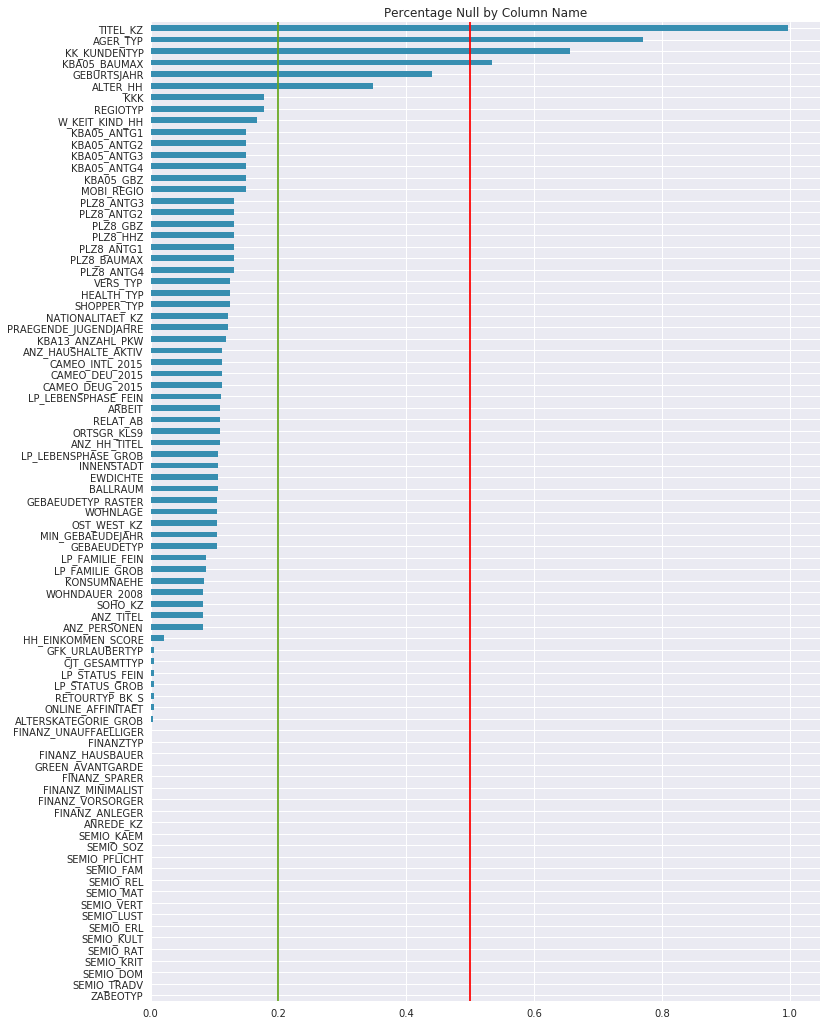

In [20]:
# Not using a histogram - prefer horizontal bar plot with 50% and 20% threshold lines
ax = new_df['Perc_Null'].plot.barh(color='#378EB1', figsize=(12, 18), title='Percentage Null by Column Name')
ax.invert_yaxis()
plt.axvline(x=0.5, color='r', linestyle='-')
plt.axvline(x=0.2, color='C4', linestyle='-');

In [21]:
# Find which columns have greater than 20% null values
col_gt_twenty = new_df.loc[new_df['Perc_Null'] > 0.2].index.tolist()

In [22]:
# Investigate patterns in the amount of missing data in each column.
my_df = pd.DataFrame(feat_info.loc[col_gt_twenty])
my_df['Perc_Null'] = new_df.loc[new_df['Perc_Null'] > 0.2][['Perc_Null']]
my_df

,information_level,type,missing_or_unknown,Text,Perc_Null
attribute,,,,,
TITEL_KZ,person,categorical,"[-1, 0]",Academic title flag,0.997576
AGER_TYP,person,categorical,"[-1, 0]",Best-ager typology,0.769554
KK_KUNDENTYP,household,categorical,[-1],Consumer pattern over past 12 months,0.655967
KBA05_BAUMAX,microcell_rr3,mixed,"[-1, 0]",Most common building type within the microcell,0.534687
GEBURTSJAHR,person,numeric,[0],Year of birth,0.440203
ALTER_HH,household,interval,[0],Birthdate of head of household,0.348137


#### Discussion 1.1.2: Assess Missing Data in Each Column


**- TITEL_KZ** is a academic flag, eg 'Dr' or 'Professor' - while it is feasible that 3% of the population have 
an academic title such as a PhD or Professorship and the other 97% do not, this is not unambiguous enough and therefore the column will be removed.

**- AGER_TYP** is an 'ager typology' - this appears to be specifically used for older members of the population. It is feasible that the 24% with labels could be the older population and 76% all other ages. However this 76% still needs their own classes to exist so the column will be removed.

**- KK_KUNDENTYP** is the consumer pattern over the past year, for example a new or regular customer. While this is helpful for insights, there is no way to impute the missing 65% so the column has to be dropped.

**- KBA05_BAUMAX** provides information about the building in which the individual lives - for example this would assist in understanding the style of apartment block, however there is no way to impute the missing 53% so the column has to be dropped.

**- GEBURTSJAHR** is the year of birth of the individual. If the percentage of nulls within the column were lower, it would be possible to impute this via a modal or mean year, however at 44% this is likely to be quite inaccurate and therefore the column has to be dropped.

**- ALTER_HH** is the year of birth of the individual identified as the head of the household. Again this could be imputed via a modal or mean age but would probably be inaccurate and the column will be dropped.

In [23]:
# Remove the outlier columns from the dataset. (Perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias = azdias.drop(col_gt_twenty, axis=1)

# Check all columns removed
assert any(item in col_gt_twenty for item in azdias.columns.tolist()) == False

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [24]:
# Counting null values per row
_ = azdias.isna().sum(axis=1)

In [25]:
# How much data is missing in each row of the dataset?
print(f'There is a total of {sum(_)} missing data within the dataset')

There is a total of 5035304 missing data within the dataset


In [26]:
# Summarising the missing data to run counts
missing_counts = _.value_counts(ascending=True).to_frame(name='Null_Count').sort_index()

# Getting percentage distribution for Null count per row
missing_counts['Perc_Null'] = missing_counts['Null_Count'] / missing_counts['Null_Count'].sum()

In [27]:
# Inserting 'Running Total' to see the cumulative contribution of the amount of missing values
missing_counts['Running_Total'] = missing_counts['Perc_Null'].cumsum(axis=0)

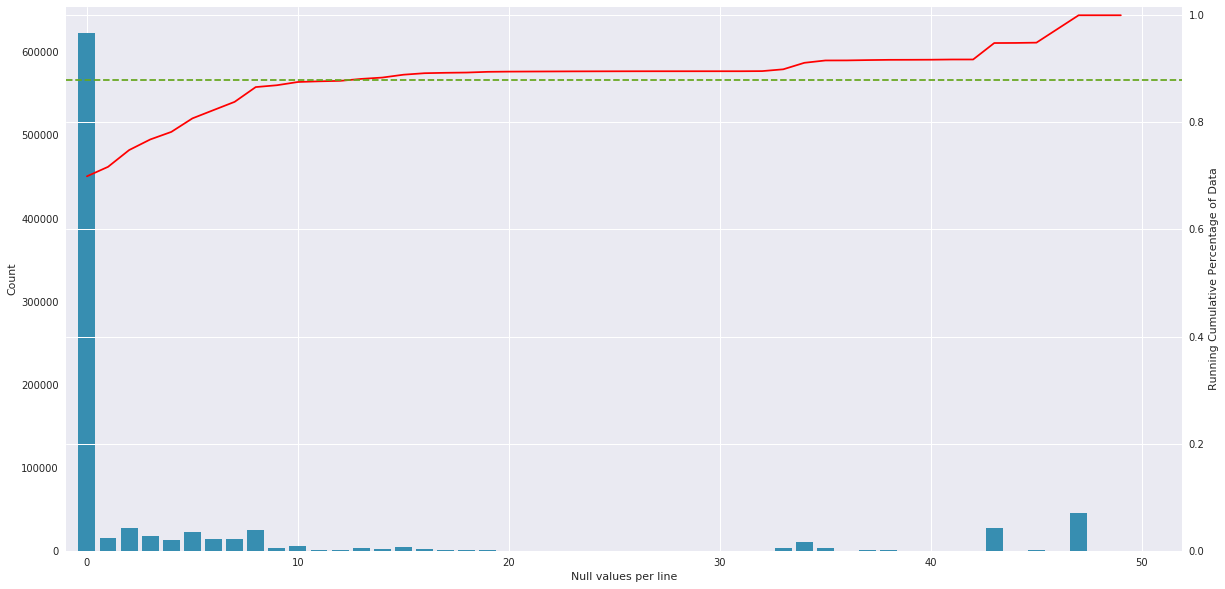

In [28]:
# Plotting the data
fig, ax_1 = plt.subplots(figsize=(20,10))

ax_1.bar(missing_counts.index, missing_counts['Null_Count'], color='#378EB1')
ax_1.set_xlim(left= -1)
ax_1.yaxis.grid(False)
ax_1.xaxis.grid(True)
ax_1.set_ylabel('Count')
ax_1.set_xlabel('Null values per line')

ax_2 = ax_1.twinx()
ax_2.plot(missing_counts['Running_Total'], color='r')
ax_2.set_ylim(bottom= 0)
ax_2.set_ylabel('Running Cumulative Percentage of Data')

plt.axhline(y=0.88, color='C4', linestyle='dashed');

In [29]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

As the rows missing 0 to 10 values per row constitute roughly 88% of the total data, I will divide the data into these two parts:
1. 0-10
2. Rest of the data

In [30]:
# Sub-divide data and check that the sum is equal to the original
to_divide = pd.concat([azdias,_], axis = 1)

missing_lt_ten = to_divide[to_divide[0] <= 10] #0-10 values missing

missing_gt_ten = to_divide[to_divide[0] > 10] #Rest of the data

assert missing_lt_ten.shape[0] + missing_gt_ten.shape[0] == to_divide.shape[0]

In [31]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

In [32]:
# Will look at 5 columns randomly chosen
columns_to_view = dict(enumerate(missing_lt_ten.columns))
random_to_view = [14,  8,  3, 12,  6]
columns_to_view = [columns_to_view[i] for i in random_to_view]

In [33]:
# Function to create summary count DataFrame for each of variables in columns_to_view
def get_summary_df(dataframe):
    """
    Creates summary count DataFrame for each variable in columns_to_view list
    """
    my_dict = {}
    dataframe = dataframe[columns_to_view]
    for column in dataframe.columns: 
        my_dict[column] = pd.Series(dataframe[column].value_counts(), name=column)
    return pd.DataFrame(my_dict)

In [34]:
# Create summary dfs for both 
gt_ten_summary = get_summary_df(missing_gt_ten)
lt_ten_summary = get_summary_df(missing_lt_ten)

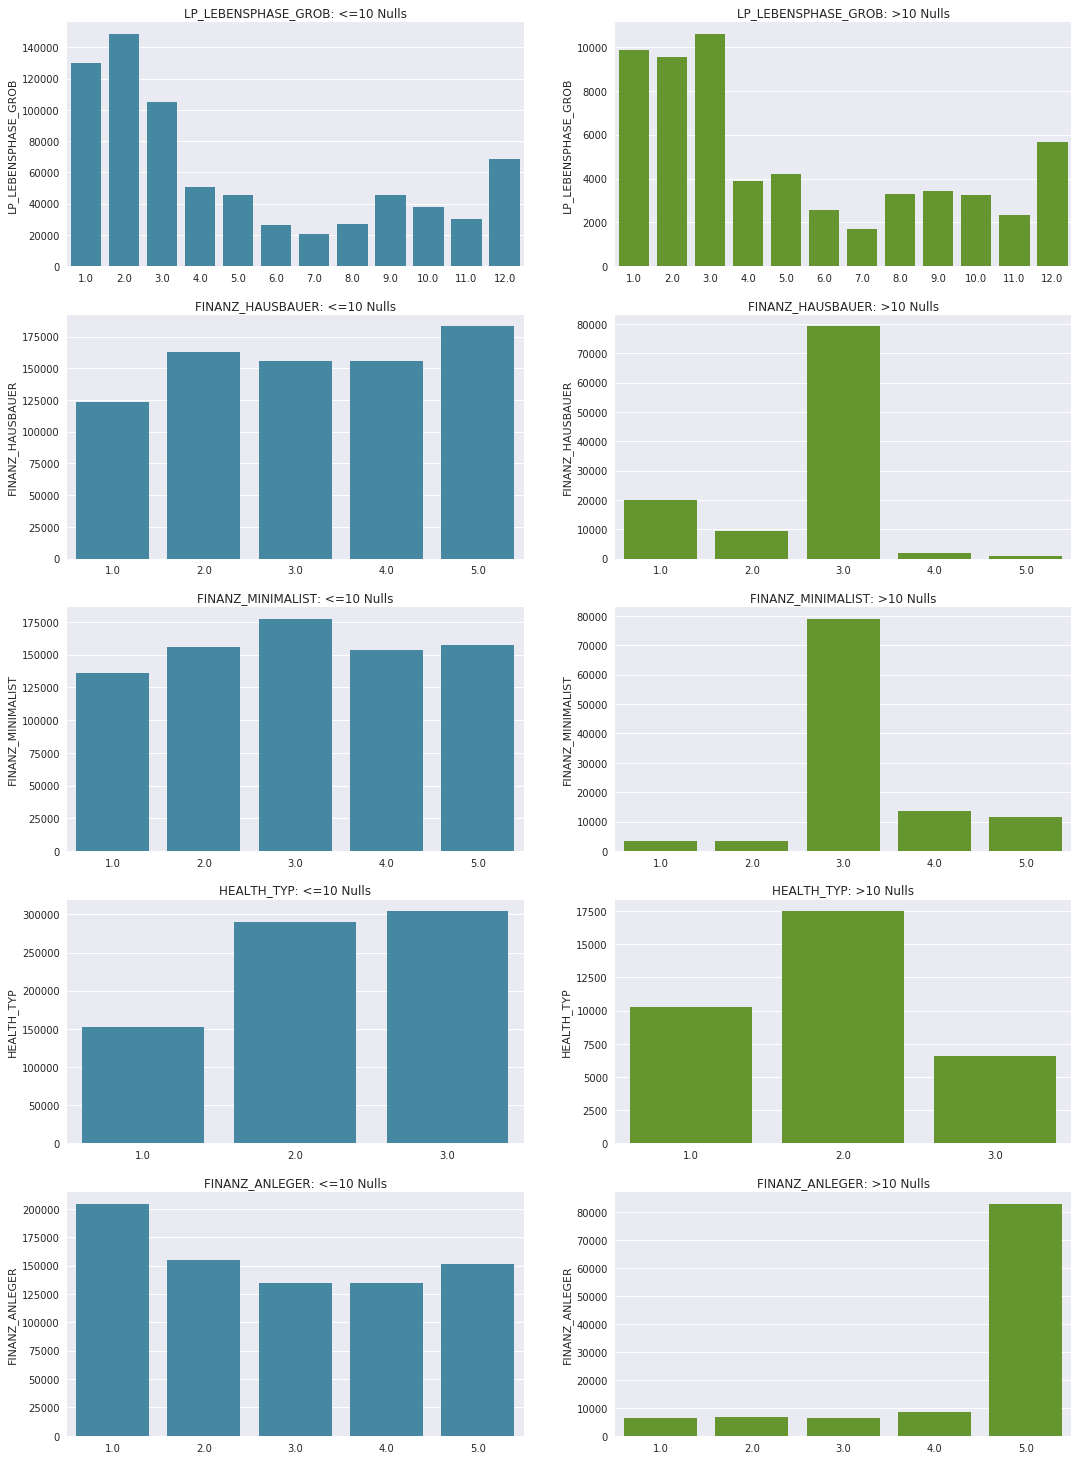

In [35]:
# Plot summary dfs and compare

# Create a Figure and an array of subplots with 5 rows and 2 columns

fig = plt.figure(figsize=(18,26))

a = 5  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter

for i in range(a):
    column = columns_to_view[i]
    for ii in range(b):
        if c % 2 != 0:
            plt.subplot(a, b, c)
            to_plot=lt_ten_summary[lt_ten_summary[column].notna()]
            sns.barplot(x=to_plot.index,y=to_plot[column], data=to_plot, color='#378EB1')
            plt.title(column + ': <=10 Nulls')
        else:
            plt.subplot(a, b, c)
            to_plot=gt_ten_summary[gt_ten_summary[column].notna()]
            sns.barplot(x=to_plot.index,y=to_plot[column], data=to_plot, color='C4')
            plt.title(column + ': >10 Nulls')
        c += 1
    
plt.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row

The distribution of the data across these 5 columns does not look very similar, indicating that the two datasets are probably qualitatively different to each other. 

While **'LP_LEBENSPHASE_GROB'** appears to have a similar distribution of values between the two datasets, **'FINANZ_HAUSBAUER'** and **'FINANZ_MINIMALIST'** have a clear median value of 3 in the data with greater than 10 nulls per row (right hand side, green columns). Similarly **'HEALTH_TYP'** has a clear median of 2. While 3 is the median within **'FINANZ_MINIMALIST'** for the dataset where there are only 0-10 values missing in each row (left hand side, blue columns), overall it does not appear to be similar.

**'FINANZ_ANLEGER'** has no similarities in distributions at all between the two datasets.

I will therefore need to revisit these and continue with a dataset where there is only 0 or 1 values missing in each row. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [36]:
# Taking only the rows where there are 0 or 1 missing values per row
df = to_divide[to_divide[0] <= 1]

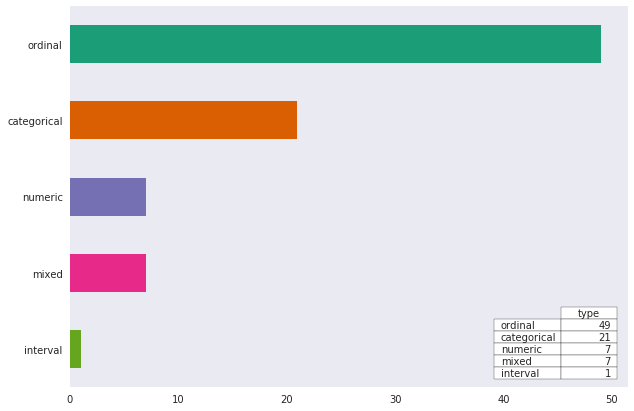

In [37]:
# Checking existing data type distribution for feat_info
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
pd.plotting.table(ax, feat_info['type'].value_counts(), loc="lower right", colWidths=[0.1])
plt.rcParams["axes.grid"] = False

feat_info['type'].value_counts().plot.barh()
ax.invert_yaxis();

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [38]:
# Getting only the categorical columns
categorical = feat_info.loc[feat_info['type'] == 'categorical'].index

In [39]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded

print('-' * 47)
print(f'{"Categorical Variables": ^47}')
print('-' * 47)
for category in categorical:
    if category in df.columns:
        level = list(df[category].value_counts().index)
        if len(level) == 2:
            if str(level[0]).isalpha():
                print(f'{category:<17s}{":":>2s}{"To be re-encoded (Binary)":>28s}')
            else:
                print(f'{category:<17s}{":":>2s}{"Binary":>28s}')
        else:
            print(f'{category:<17s}{":":>2s}{"Multi-level":>28s}')

-----------------------------------------------
             Categorical Variables             
-----------------------------------------------
ANREDE_KZ         :                      Binary
CJT_GESAMTTYP     :                 Multi-level
FINANZTYP         :                 Multi-level
GFK_URLAUBERTYP   :                 Multi-level
GREEN_AVANTGARDE  :                      Binary
LP_FAMILIE_FEIN   :                 Multi-level
LP_FAMILIE_GROB   :                 Multi-level
LP_STATUS_FEIN    :                 Multi-level
LP_STATUS_GROB    :                 Multi-level
NATIONALITAET_KZ  :                 Multi-level
SHOPPER_TYP       :                 Multi-level
SOHO_KZ           :                      Binary
VERS_TYP          :                      Binary
ZABEOTYP          :                 Multi-level
GEBAEUDETYP       :                 Multi-level
OST_WEST_KZ       :   To be re-encoded (Binary)
CAMEO_DEUG_2015   :                 Multi-level
CAMEO_DEU_2015    :                 Mult

In [40]:
# Re-encode categorical variable(s) to be kept in the analysis.

In [41]:
# Start with the Variable 'OST_WEST_KZ' as it is binary but needs to be re-encoded.
df['OST_WEST_KZ'].value_counts()

W    502748
O    136199
Name: OST_WEST_KZ, dtype: int64

In [42]:
# 'OST_WEST_KZ' will be re-encoded as 'O' = 0 and 'W' = 1
df['OST_WEST_KZ'].replace({'O': 0, 'W': 1}, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [43]:
# Creating function to re-cast datatypes to category

def recasts_to_category_dt(dataframe):
    """
    Recasts columns to a categorical datatype if they are identified as categorical by the Feature Info document 
    """
    multi_lev_dt = []
    for category in categorical:
        if category in dataframe.columns:
            level = list(dataframe[category].value_counts().index)
            multi_lev_dt.append((category, dataframe[category].dtypes))

    multi_lev_dt = [level[0] for level in multi_lev_dt if level[1] == 'float64']        

    for col in multi_lev_dt:
        dataframe[col] = dataframe[col].astype('category')
    
    return dataframe

In [44]:
df = recasts_to_category_dt(df)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [45]:
# Investigating Multi-level Categorical Variables to see which to drop

print('-' * 110)
print(f'{"Multi-level Categorical Variables": ^110}')
print('-' * 110)
my_list = []      
      
for category in categorical:
    if category in df.columns:
      level = list(df[category].value_counts().index)
      if len(level) == 2:
          continue
      my_list.append(df[category].value_counts())
      print(f'{category:<18s}{":":<3s}{feat_info.loc[category][3]:<88s}')

--------------------------------------------------------------------------------------------------------------
                                      Multi-level Categorical Variables                                       
--------------------------------------------------------------------------------------------------------------
CJT_GESAMTTYP     :  Customer-Journey-Typology: preferred information and buying channels for                
FINANZTYP         :  Most descriptive financial type for individual                                          
GFK_URLAUBERTYP   :  Vacation habits                                                                         
LP_FAMILIE_FEIN   :  Family type, fine scale                                                                 
LP_FAMILIE_GROB   :  Family type, rough scale                                                                
LP_STATUS_FEIN    :  Social status, fine scale                                                               
LP_STAT

In [46]:
# Looking for Multi-level Categorical Variables where one value dominates the distribution -- indicates that 
# the variable is a latent feature, holds redundant data and can be dropped.

# Please note that the distribution for 'CAMEO_DEU_2015' is not shown below.

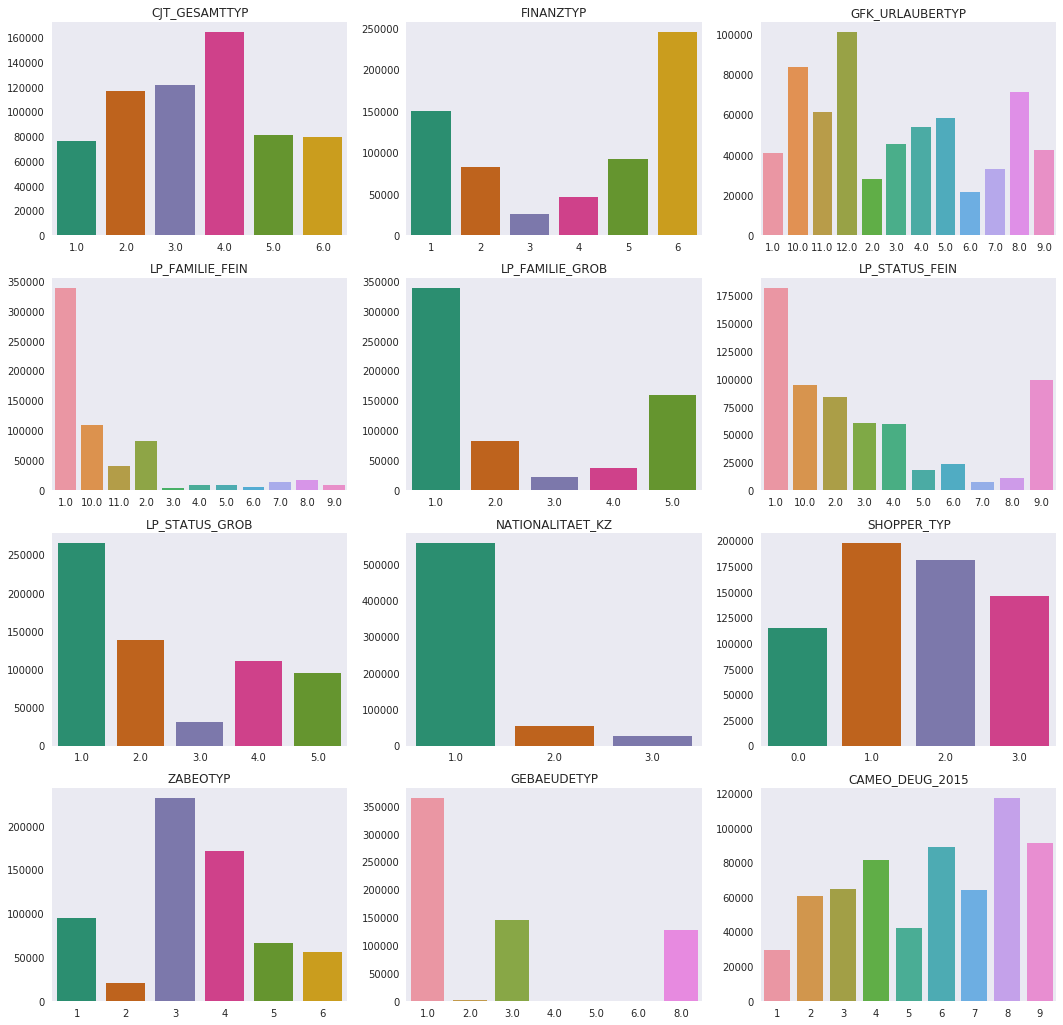

In [47]:
c = 1  # Plot counter

fig = plt.figure(figsize=(18,18))

for i in my_list[0:-1]:
    plt.subplot(4, 3, c)
    plt.title(i.name)
    x_labels = [str(item) for item in i.index]
    sns.barplot(x=x_labels,y=i.values)
    c += 1

plt.show()

**Skewed Feature distributions to drop**

Distributions for 'GEBAEUDETYP' and 'NATIONALITAET_KZ' immediately look skewed to certain values, according to the chart from above. 

The Data Dictionary defines 'GEBAEUDETYP' as the building type. This is highly skewed to residential buildings as expected from consumer data - this is redundant information and can be dropped.

'NATIONALITAET_KZ' is highly skewed towards German nationality - this is also expected as the data originates from 
Germany. This can therefore also be dropped as it appears to be generally redundant.

In [48]:
df = df.drop(['GEBAEUDETYP','NATIONALITAET_KZ'], axis=1)

assert set(df.columns.isin(['GEBAEUDETYP','NATIONALITAET_KZ'])) == {False}

**Uninformative Features to drop**

'FINANZTYP' has a high occurrence of type 6, which is defined as the 'inconspicuous financial type'. It is not clear what this definition refers to (how can a person be financially inconspicuous) - so this will be dropped.

Similarly, 'SHOPPER_TYP' - the majority of people are type 1 ('Shopping stressed') - a clearer definition would 
be better, so the column will be dropped.

While 'LP_FAMILIE_FEIN' is a more granular version of 'LP_FAMILIE_GROB', it doesn't appear that the granularity is
necessary and 'LP_FAMILIE_FEIN' can be dropped.

Similarly for 'LP_STATUS_FEIN' versus 'LP_STATUS_GROB' - the social status on a rough scale should suffice for the 
model at this point.

Also 'CAMEO_DEU_2015' will be dropped for 'CAMEO_DEUG_2015' as 'CAMEO_DEUG_2015' still contains salient data for the model.

In [49]:
df = df.drop(['FINANZTYP','SHOPPER_TYP','LP_FAMILIE_FEIN','LP_STATUS_FEIN', 'CAMEO_DEU_2015'], axis=1)

assert set(df.columns.isin(['FINANZTYP','SHOPPER_TYP','LP_FAMILIE_FEIN','LP_STATUS_FEIN', 'CAMEO_DEU_2015'])) \
== {False}

**Latent Values to replace features**

Within 'CJT_GESAMTTYP', in terms of 'preferred information' (definition from the Data Dictionary) it appears that all of the population are associated with advertising. Types 5 and 6 (consumers using cross channels) can be combined to reduce features.

'GFK_URLAUBERTYP' can be summarised as replacing 1 to 11 with a positive (1) for vacation, and 12 ('Without vacation') will become 0.

For 'LP_FAMILIE_GROB', types 3, 4 and 5 can be combined as it is likely that these are families, or are households with children.

Within 'LP_STATUS_GROB', types 3, 4 and 5 can also be combined as these appear to be higher income consumers.

Within 'ZABEOTYP', types 2 (smart), 4 (price-driven) and 5 (seeking orientation) can be combined as these appear to be price-conscious consumers.

The remaining features will be kept as is and dummy-encoded.

In [50]:
# Combining 5 and 6 within 'CJT_GESAMTTYP'
df['CJT_GESAMTTYP'] = df['CJT_GESAMTTYP'].replace({6:5})

# Remapping 1-11 as 1 for vacation and 12 as 0 for vacation within 'GFK_URLAUBERTYP'
df['GFK_URLAUBERTYP'] = [1 if val <= 11 else 0 for val in df['GFK_URLAUBERTYP'].values]

# Remapping 3, 4 and 5 as 3 as this indicates children within 'LP_FAMILIE_GROB'
df['LP_FAMILIE_GROB'] = [3 if int(val) > 3 else int(val) for val in df['LP_FAMILIE_GROB'].values]

# Remapping 3, 4 and 5 as 3 as this indicates higher financial status within 'LP_STATUS_GROB'
df['LP_STATUS_GROB'] = [3 if int(val) > 3 else int(val) for val in df['LP_STATUS_GROB'].values]

# Remapping 2, 4 and 5 as 2 as this indicates higher financial status within 'ZABEOTYP'
df['ZABEOTYP'] = df['ZABEOTYP'].replace({4:2, 5:2})

#### Discussion 1.2.1: Re-Encode Categorical Features

**Categorical Features kept**

'CAMEO_DEUG_2015' was kept the same as it was supplied, all other multi-category features were either re-engineered or dropped.
The Binary variables 'ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ' and 'VERS_TYP' were kept as-is. 'OST_WEST_KZ' was re-encoded as 'O' = 0 and 'W' = 1, but no other re-engineering steps were taken.

**Categorical Features dropped**

'FINANZTYP' and 'SHOPPER_TYP' were dropped because their definitions did not make enough meaningful sense to be kept.
'LP_FAMILIE_FEIN', 'CAMEO_DEU_2015' and 'LP_STATUS_FEIN' were dropped for their broader-defined counterparts.
'GEBAEUDETYP' and 'NATIONALITAET_KZ' were dropped because they appeared obvious to the dataset (i.e the majority of people in Germany are German and live in a residence).

**Engineering steps performed**

'GFK_URLAUBERTYP' was re-engineered to become binary (those positive or negative for being holiday makers).
Other variables re-engineered were 'CJT_GESAMTTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB' and 'ZABEOTYP' as all these contained values that could be consolidated into single values.

*Please see above for additional rationale and discussion.*

In [51]:
# Converting columns to dummy encoding

dummies = ['CJT_GESAMTTYP','LP_FAMILIE_GROB','LP_STATUS_GROB', 'ZABEOTYP', 'CAMEO_DEUG_2015']

df = pd.get_dummies(df, columns=dummies)

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [52]:
# Getting only the mixed-type columns
mixed = feat_info.loc[feat_info['type'] == 'mixed'].index
mixed = [attribute for attribute in mixed if attribute in df.columns]

In [53]:
# Re-casting the float datatypes to category
for col in mixed:
    df[col] = df[col].astype('category')
    assert df[col].dtype == 'category'

In [54]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

In [55]:
# Getting full definition of 'PRAEGENDE_JUGENDJAHRE' according to the Data Dictionary
pj_text_ = Data_dict_import.get_full_dictionary_def('PRAEGENDE_JUGENDJAHRE')
pj_text_

['PRAEGENDE_JUGENDJAHRE',
 "Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)",
 '- -1: unknown',
 '-  0: unknown',
 '-  1: 40s - war years (Mainstream, E+W)',
 '-  2: 40s - reconstruction years (Avantgarde, E+W)',
 '-  3: 50s - economic miracle (Mainstream, E+W)',
 '-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)',
 '-  5: 60s - economic miracle (Mainstream, E+W)',
 '-  6: 60s - generation 68 / student protestors (Avantgarde, W)',
 '-  7: 60s - opponents to the building of the Wall (Avantgarde, E)',
 '-  8: 70s - family orientation (Mainstream, E+W)',
 '-  9: 70s - peace movement (Avantgarde, E+W)',
 '- 10: 80s - Generation Golf (Mainstream, W)',
 '- 11: 80s - ecological awareness (Avantgarde, W)',
 '- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)',
 '- 13: 80s - Swords into ploughshares (Avantgarde, E)',
 '- 14: 90s - digital media kids (Mainstream, E+W)',
 '- 15: 90s - ecological awareness (Avantgarde, E+W)']

In [56]:
# Parse text to the value mappings so that these can be converted to a dictionary
pj_text = {}

for text in pj_text_[4:]:
    t1, t2 = text.split(':')
    pj_text[int(t1.strip('- '))] = t2.strip()

In [57]:
# Dropping null values within PRAEGENDE_JUGENDJAHRE
df = df.dropna(subset=['PRAEGENDE_JUGENDJAHRE'])

In [58]:
# Mapping the dictionary across the Dataframe to summarise for Decade and Mainstream Y/N
decade_pj_dict = {}
for key, val in pj_text.items():
    decade = '19' + val[0:2]
    decade_pj_dict[key] = decade

df['PRAEGENDE_JUGENDJAHRE'] = df['PRAEGENDE_JUGENDJAHRE'].astype('int')

df['DECADE_PRAEGENDE_JUGENDJAHRE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_pj_dict)

mainstream_pj_dict = {}
for key, val in pj_text.items():
    if 'Mainstream' in val:
        mainstream_pj_dict[key] = 1 # Mainstream encoded as 1
    else:
        mainstream_pj_dict[key] = 0 # Avantgarde re-coded as 0 

df['MAINSTREAM_PRAEGENDE_JUGENDJAHRE'] = df['PRAEGENDE_JUGENDJAHRE'].map(mainstream_pj_dict) 

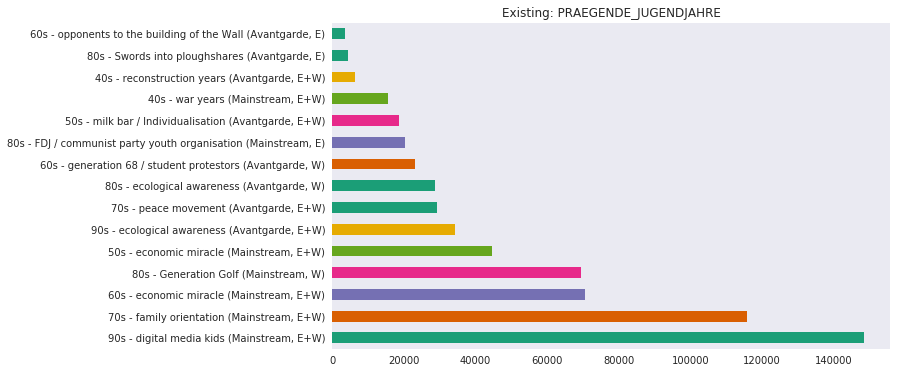

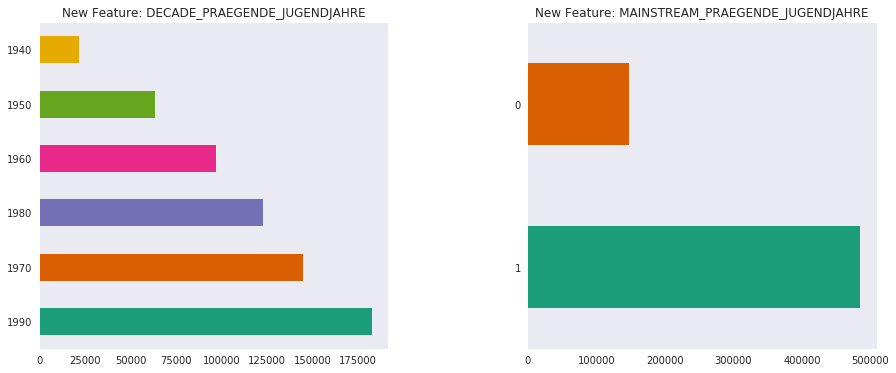

In [59]:
# Visually confirming that the two new features have the same cumulative distribution as the old

fig = plt.figure(figsize=(10,6))
df['PRAEGENDE_JUGENDJAHRE'].map(pj_text).value_counts().plot.barh(legend=False)
plt.title('Existing: PRAEGENDE_JUGENDJAHRE')

fig = plt.figure(figsize=(15,6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

df['DECADE_PRAEGENDE_JUGENDJAHRE'].value_counts().plot.barh(ax=ax1, legend=False)
df['MAINSTREAM_PRAEGENDE_JUGENDJAHRE'].value_counts().plot.barh(ax=ax2, legend=False)

ax1.set_title('New Feature: DECADE_PRAEGENDE_JUGENDJAHRE')
ax2.set_title('New Feature: MAINSTREAM_PRAEGENDE_JUGENDJAHRE');

In [60]:
# Engineering the two new variables from CAMEO_INTL_2015
_ = df['CAMEO_INTL_2015'].values
df['WEALTH'] = [str(val)[0] for val in _]
df['LIFE_STAGE'] = [str(val)[1] for val in _]

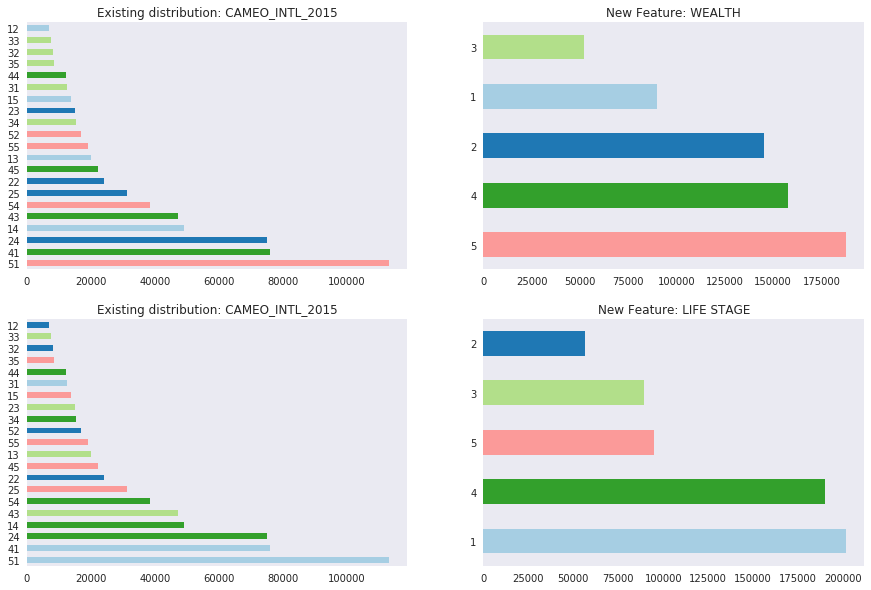

In [61]:
# Visually confirming that the two new features have the same cumulative distribution as the old 

fig = plt.figure(figsize=(15,10))

nums = [str(i) for i in range(1,6)]
colours = sns.color_palette("Paired")[:5]
colour_dict = dict(zip(nums, colours))

_ = df['CAMEO_INTL_2015'].value_counts(dropna=False)
_.index = [int(index) for index in _.index]
my_col_idx1 = [str(z)[0] for z in _.index]
my_col_idx2 = [str(z)[1] for z in _.index]

ax1 = fig.add_subplot(221)
df['CAMEO_INTL_2015'].value_counts().plot.barh(ax=ax1, legend=False, color = \
                                               [colour_dict[idx] for idx in my_col_idx1], title='Existing distribution: CAMEO_INTL_2015')
ax2 = fig.add_subplot(222)
df['WEALTH'].value_counts().plot.barh(ax=ax2, legend=False, \
                                      color=[colour_dict[idx] for idx in df['WEALTH'].value_counts().index], title='New Feature: WEALTH')
ax3 = fig.add_subplot(223)
df['CAMEO_INTL_2015'].value_counts().plot.barh(ax=ax3, legend=False, \
                                               color = [colour_dict[idx] for idx in my_col_idx2], title='Existing distribution: CAMEO_INTL_2015')
ax4 = fig.add_subplot(224)
df['LIFE_STAGE'].value_counts().plot.barh(ax=ax4, legend=False, \
                                          color=[colour_dict[idx] for idx in df['LIFE_STAGE'].value_counts().index], title='New Feature: LIFE STAGE');

From the above one can visually confirm that the existing features are mapping correctly to the new features, eg:
- Wealth: the lines coloured pink within the first CAMEO_INTL_2015 are for features starting with a '5' - cumulatively these bars correspond to the single pink bar labelled '5' in the WEALTH distribution.
- Life stage: the lines coloured light blue within the second CAMEO_INTL_2015 are for features where the second digit starts with a '1' - cumulatively these bars correspond to the single light blue bar labelled '1' in the LIFE STAGE distribution.

--------------------------------------------------------------------------------------------------------------
                                               Mixed Variables                                                
--------------------------------------------------------------------------------------------------------------
LP_LEBENSPHASE_FEIN    :  Life stage, fine scale                                                              
LP_LEBENSPHASE_GROB    :  Life stage, rough scale                                                             
WOHNLAGE               :  Neighborhood quality (or rural flag)                                                
PLZ8_BAUMAX            :  Most common building type within the PLZ8 region                                    


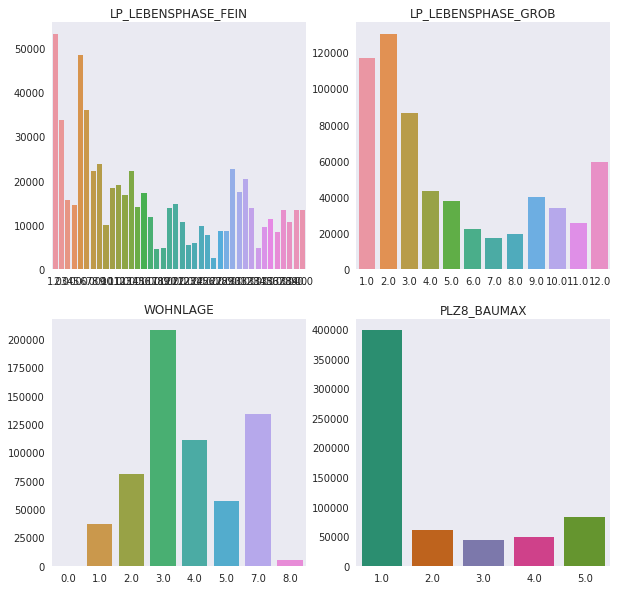

In [62]:
# Investigating the remaining mixed Variables - printing definitions and distributions for the investigation

print('-' * 110)
print(f'{"Mixed Variables": ^110}')
print('-' * 110) 
      
c = 1  

fig = plt.figure(figsize=(10,10))

for mix in mixed:
    if mix in ('CAMEO_INTL_2015','PRAEGENDE_JUGENDJAHRE'):
          continue
    if mix in df.columns:
          print(f'{mix:<23s}{":":<3s}{feat_info.loc[mix][3]:<84s}')
    
    plt.subplot(2, 2, c)
    plt.title(mix)
    i = df[mix].value_counts(dropna=False)
    sns.barplot(x=i.index,y=i.values)
    c += 1

plt.show()

Within the **'WOHNLAGE'** variable, I will condense the neighborhoods further:
-  1: very good neighborhood
-  2: good neighborhood

Will become '1 - 'good neighborhood'

-  4: poor neighborhood
-  5: very poor neighborhood

Will become '3 - poor neighborhood'

-  7: rural neighborhood
-  8: new building in rural neighborhood

Will become '4 - rural neighborhood'

Resulting values will be:
- '1 - good neighborhood'
- '2 - average neighborhood'
- '3 - poor neighborhood'
- '4 - rural neighborhood'

**'PLZ8_BAUMAX'** will be dropped because there is a dominance of value '1: mainly 1-2 family homes' - information can be inferred easily anyway.

Both **'LP_LEBENSPHASE_FEIN'** and **'LP_LEBENSPHASE_GROB'** will be dropped because the information for income is already contained in the new feature **'WEALTH'** and the details about the family size are also contained within **'LP_FAMILIE_GROB'**

In [63]:
# Making these changes - Dropping columns

df = df.drop(['CAMEO_INTL_2015','PRAEGENDE_JUGENDJAHRE', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PLZ8_BAUMAX'], axis=1)

assert set(df.columns.isin(['CAMEO_INTL_2015','PRAEGENDE_JUGENDJAHRE', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PLZ8_BAUMAX'])) == {False}

In [64]:
# Mapping condensed column values 
df['WOHNLAGE'] = df['WOHNLAGE'].map({1:'1', 2:'1', 3:'2', 4:'3', 5:'3', 7:'4', 8:'4'})

#### Discussion 1.2.2: Engineer Mixed-Type Features

**Mixed-Type Features kept**
None of the mixed-type features were kept as they initially existed.

**Mixed-Type Features dropped**
'LP_LEBENSPHASE_FEIN' and 'LP_LEBENSPHASE_GROB' were dropped because the information for income and details about the family size were already contained within 'LP_FAMILIE_GROB'.
'PLZ8_BAUMAX' was dropped as it is expected that the person will have 1 or 2 homes.

**Engineering steps performed**
'CAMEO_INTL_2015' and 'PRAEGENDE_JUGENDJAHRE' were re-engineered to create new variables. 'WEALTH' and  'LIFE_STAGE' were created from splitting the information from 'CAMEO_INTL_2015'. 
'PRAEGENDE_JUGENDJAHRE' was split to create 2 new variables: 'MAINSTREAM_PRAEGENDE_JUGENDJAHRE' reflects whether a person is 'Mainstream' or not ('Avant-garde' being the opposite here). Similarly 'DECADE_PRAEGENDE_JUGENDJAHRE' is the dominant decade of the person's youth.
'WOHNLAGE' was re-engineered to have higher-level detail, this involved condensing neighborhood types (eg - 'very good and 'good' were condensed to a single 'Good').

*Please see above for additional rationale.*

In [65]:
# Converting columns to dummy encoding

dummies = ['WEALTH','LIFE_STAGE','WOHNLAGE','DECADE_PRAEGENDE_JUGENDJAHRE']

df = pd.get_dummies(df, columns=dummies)

In [66]:
# Visually checking dataframe
df.head(3)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,0,CJT_GESAMTTYP_1,CJT_GESAMTTYP_2,CJT_GESAMTTYP_3,CJT_GESAMTTYP_4,CJT_GESAMTTYP_5,LP_FAMILIE_GROB_1,LP_FAMILIE_GROB_2,LP_FAMILIE_GROB_3,LP_STATUS_GROB_1,LP_STATUS_GROB_2,LP_STATUS_GROB_3,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_6,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MAINSTREAM_PRAEGENDE_JUGENDJAHRE,WEALTH_1,WEALTH_2,WEALTH_3,WEALTH_4,WEALTH_5,LIFE_STAGE_1,LIFE_STAGE_2,LIFE_STAGE_3,LIFE_STAGE_4,LIFE_STAGE_5,WOHNLAGE_1,WOHNLAGE_2,WOHNLAGE_3,WOHNLAGE_4,DECADE_PRAEGENDE_JUGENDJAHRE_1940,DECADE_PRAEGENDE_JUGENDJAHRE_1950,DECADE_PRAEGENDE_JUGENDJAHRE_1960,DECADE_PRAEGENDE_JUGENDJAHRE_1970,DECADE_PRAEGENDE_JUGENDJAHRE_1980,DECADE_PRAEGENDE_JUGENDJAHRE_1990
1,1.0,2,1,5,2,5,4,5,1,0,3.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,1,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,3.0,2,1,4,1,2,3,5,1,1,3.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,1,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
4,3.0,1,4,3,4,1,3,2,1,0,3.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,1,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,6.0,5.0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [67]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [68]:
df = df.drop([0], axis=1)

In [69]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

In [70]:
# Only mixed and continuous variables with nulls remain - will use the Imputer for these

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [71]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    Input:  Demographics DataFrame
    Output: Trimmed and cleaned demographics DataFrame
    """
    
    # Creating new Dataframe where missing values replaced with NaN
    df = converts_to_na(df)
    
    # dropping initial columns
    df = df.drop(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'], axis=1)

    # Counting null values per row
    _ = df.isna().sum(axis=1)
    df = pd.concat([df,_], axis = 1)
    
    # Taking only the rows where there are 0 or 1 missing values per row
    df = df[df[0] <= 1]
    
    # 'OST_WEST_KZ' re-encoded as 'O' = 0 and 'W' = 1
    df['OST_WEST_KZ'].replace({'O': 0, 'W': 1}, inplace=True)
    
    #re-cast datatypes to category
    df = recasts_to_category_dt(df)
    
    #Drop skewed and uninformative features
    df = df.drop(['GEBAEUDETYP','NATIONALITAET_KZ', 'FINANZTYP','SHOPPER_TYP','LP_FAMILIE_FEIN','LP_STATUS_FEIN', 'CAMEO_DEU_2015'], axis=1)

    # Combining 5 and 6 within 'CJT_GESAMTTYP'
    df['CJT_GESAMTTYP'] = df['CJT_GESAMTTYP'].replace({6:5})
    
    # Remapping 1-11 as 1 for vacation and 12 as 0 for vacation within 'GFK_URLAUBERTYP'
    df['GFK_URLAUBERTYP'] = [1 if val <= 11 else 0 for val in df['GFK_URLAUBERTYP'].values]

    # Remapping 3, 4 and 5 as 3 as this indicates children within 'LP_FAMILIE_GROB'
    df['LP_FAMILIE_GROB'] = [3 if int(val) > 3 else int(val) for val in df['LP_FAMILIE_GROB'].values]

    # Remapping 3, 4 and 5 as 3 as this indicates higher financial status within 'LP_STATUS_GROB'
    df['LP_STATUS_GROB'] = [3 if int(val) > 3 else int(val) for val in df['LP_STATUS_GROB'].values]

    # Remapping 2, 4 and 5 as 2 as this indicates higher financial status within 'ZABEOTYP'
    df['ZABEOTYP'] = df['ZABEOTYP'].replace({4:2, 5:2})
    
    # Converting columns to dummy encoding
    dummies = ['CJT_GESAMTTYP','LP_FAMILIE_GROB','LP_STATUS_GROB', 'ZABEOTYP', 'CAMEO_DEUG_2015']

    df = pd.get_dummies(df, columns=dummies)
    
    # Re-casting the float datatypes to category
    for col in mixed:
        df[col] = df[col].astype('category')

    df = df.dropna(subset=['PRAEGENDE_JUGENDJAHRE'])
    
    df['PRAEGENDE_JUGENDJAHRE'] = df['PRAEGENDE_JUGENDJAHRE'].astype('int')

    df['DECADE_PRAEGENDE_JUGENDJAHRE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_pj_dict)

    df['MAINSTREAM_PRAEGENDE_JUGENDJAHRE'] = df['PRAEGENDE_JUGENDJAHRE'].map(mainstream_pj_dict) 

    # Engineering two new variables from CAMEO_INTL_2015
    
    _ = df['CAMEO_INTL_2015'].values
    df['WEALTH'] = [str(val)[0] for val in _]
    df['LIFE_STAGE'] = [str(val)[1] for val in _]
    
    # Dropping further columns

    df = df.drop(['CAMEO_INTL_2015','PRAEGENDE_JUGENDJAHRE', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PLZ8_BAUMAX'], axis=1)

    # Mapping condensed column values 
    
    df['WOHNLAGE'] = df['WOHNLAGE'].map({1:'1', 2:'1', 3:'2', 4:'3', 5:'3', 7:'4', 8:'4'})

    # Converting columns to dummy encoding

    dummies = ['WEALTH','LIFE_STAGE','WOHNLAGE','DECADE_PRAEGENDE_JUGENDJAHRE']

    df = pd.get_dummies(df, columns=dummies)
    
    
    df = df.drop([0], axis=1)
    
    # Return the cleaned dataframe.
    return df
    

In [72]:
# Checking function works as expected - re-running on random sample of original dataset

line_num = sum(1 for l in open('./Udacity_AZDIAS_Subset.csv'))
sample_15 = int(line_num / 15) 

rand_idx = random.sample(range(1,line_num), line_num - sample_15) #Taking 15% of original rows

sample = pd.read_csv('./Udacity_AZDIAS_Subset.csv', delimiter=';', skiprows=rand_idx)

_ = clean_data(sample)
_.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (57,59) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1,CJT_GESAMTTYP_2,CJT_GESAMTTYP_3,CJT_GESAMTTYP_4,CJT_GESAMTTYP_5,LP_FAMILIE_GROB_1,LP_FAMILIE_GROB_2,LP_FAMILIE_GROB_3,LP_STATUS_GROB_1,LP_STATUS_GROB_2,LP_STATUS_GROB_3,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_6,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MAINSTREAM_PRAEGENDE_JUGENDJAHRE,WEALTH_1,WEALTH_2,WEALTH_3,WEALTH_4,WEALTH_5,LIFE_STAGE_1,LIFE_STAGE_2,LIFE_STAGE_3,LIFE_STAGE_4,LIFE_STAGE_5,WOHNLAGE_1,WOHNLAGE_2,WOHNLAGE_3,WOHNLAGE_4,DECADE_PRAEGENDE_JUGENDJAHRE_1940,DECADE_PRAEGENDE_JUGENDJAHRE_1950,DECADE_PRAEGENDE_JUGENDJAHRE_1960,DECADE_PRAEGENDE_JUGENDJAHRE_1970,DECADE_PRAEGENDE_JUGENDJAHRE_1980,DECADE_PRAEGENDE_JUGENDJAHRE_1990
0,1.0,2,1,5,2,5,4,5,1,0,3.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,1,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,2.0,2,2,2,4,1,3,4,1,0,2.0,3.0,2,5,4,7,2,2,5,2,6,5,7,7,5,7,0.0,2.0,4.0,0.0,4.0,4.0,9.0,3.0,0.0,1.0,1992.0,1,1.0,3.0,0.0,0.0,3.0,1.0,6.0,2.0,3.0,1.0,2.0,2.0,1.0,439.0,1.0,3.0,2.0,1.0,5.0,3.0,3.0,8.0,5.0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,1.0,2,1,4,2,2,4,3,1,0,3.0,2.0,1,4,4,3,1,2,4,2,6,5,6,6,5,6,0.0,2.0,1.0,0.0,5.0,6.0,4.0,10.0,0.0,1.0,1992.0,1,0.0,0.0,2.0,1.0,1.0,1.0,6.0,1.0,3.0,1.0,2.0,5.0,3.0,378.0,1.0,4.0,3.0,2.0,5.0,3.0,4.0,9.0,3.0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,3.0,2,2,4,4,4,2,3,1,0,3.0,5.0,2,3,3,3,2,1,6,3,4,7,7,7,5,3,0.0,2.0,2.0,0.0,5.0,4.0,9.0,7.0,0.0,2.0,1992.0,1,2.0,3.0,0.0,0.0,3.0,7.0,4.0,7.0,4.0,2.0,3.0,0.0,6.0,363.0,2.0,4.0,2.0,0.0,3.0,3.0,4.0,4.0,5.0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
7,3.0,2,2,3,4,3,2,3,1,0,2.0,5.0,1,1,3,2,2,6,6,3,4,6,6,7,5,3,0.0,1.0,2.0,0.0,5.0,3.0,3.0,8.0,0.0,1.0,1994.0,1,0.0,3.0,2.0,0.0,2.0,6.0,6.0,2.0,2.0,2.0,1.0,4.0,3.0,228.0,1.0,4.0,3.0,1.0,3.0,2.0,4.0,7.0,4.0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [73]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

-----------------------------------------------------------------------------------------------
                     Other Variables: Null Count, Data Type and Definition                     
-----------------------------------------------------------------------------------------------
W_KEIT_KIND_HH        :  7279  :  ordinal  :  Likelihood of children in household                             
ANZ_HAUSHALTE_AKTIV   :  1699  :  numeric  :  Number of households in the building                            
KONSUMNAEHE           :  31    :  ordinal  :  Distance from building to point of sale (PoS)                   
KBA13_ANZAHL_PKW      :  502   :  numeric  :  Number of cars in the PLZ8 region                               


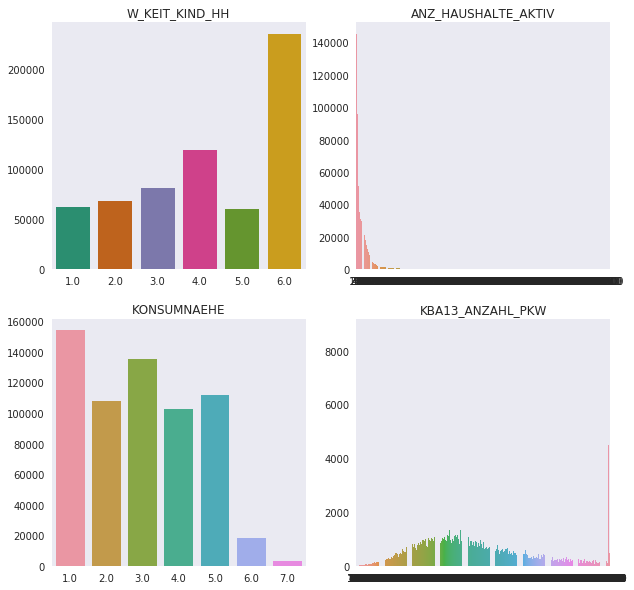

In [74]:
# Investigate the remaining mixed Variables with Nulls - printing definitions and distributions for the investigation

print('-' * 95)
print(f'{"Other Variables: Null Count, Data Type and Definition": ^95}')
print('-' * 95) 
      
c = 1  

fig = plt.figure(figsize=(10,10))

for idx in df.columns[df.isna().any()]:
    print(f'{idx:<22s}{":":<3s}{str(df[idx].isnull().sum()):<6s}{":":<3s}{feat_info.loc[idx][1]:<9s}{":":<3s}{feat_info.loc[idx][3]:<64s}')
    plt.subplot(2, 2, c)
    plt.title(idx)
    i = df[idx].value_counts(dropna=False)
    sns.barplot(x=i.index,y=i.values)
    c += 1

plt.show()

For **W_KEIT_KIND_HH** I will apply the ceiling of the mean of the existing values within the column to impute the likelihood of children in the household - as this calculates to 4 or 'average', this is an acceptable value to substitute in for the nulls.

For **ANZ_HAUSHALTE_AKTIV** I will apply the mode to impute the number of households in the building - as this is the most frequntly occurring value it is an acceptable substitute here too.

For **KONSUMNAEHE** I will take the ceiling of the mean again, to impute the average distance from building to point of sale.

For **KBA13_ANZAHL_PKW** I will again use the mode to impute missing values - as this variable is to do with the number of cars in the PLZ8 region, using the mode is an acceptable solution for null values. 

In [75]:
# Creating function to run the impute with sklearn.Imputer

def create_imputed_values(columns, impute_strategy, dataframe):
    """
    Performs imputation for columns, according to sklearn impute strategy
    Inputs: 
        columns:           columns to run imputation on - (list)
        impute_strategy:   specifed by sklearn's Imputer (mean, median, most_frequent or constant) - (string)
        dataframe:         original dataframe where columns exist - (dataframe) 
    Output:                DataFrame with imputed columns
    """
    my_df = dataframe[columns]
    imp = Imputer(strategy=impute_strategy)
    _ = imp.fit_transform(my_df)
    _ = pd.DataFrame(_, columns=my_df.columns, index=dataframe.index)
    
    my_list = ['_' + i for i in columns]
    my_dict = dict(zip(columns, my_list)) 
    dataframe = dataframe.rename(columns=my_dict)
    
    to_drop = list(my_dict.values())
    dataframe = dataframe.drop(to_drop, axis=1)
    dataframe = pd.concat([dataframe, _], axis=1)
    return dataframe

In [76]:
# Imputing Nulls as explained above

df = create_imputed_values(['ANZ_HAUSHALTE_AKTIV','KBA13_ANZAHL_PKW'], "most_frequent", df) #Imputing with the mode

In [77]:
df = create_imputed_values(['W_KEIT_KIND_HH','KONSUMNAEHE'], "mean", df) #Imputing with the mean

In [78]:
# Checking impute function worked
for column in df.columns[-4:]: 
    assert df[column].isna().any() == False

In [79]:
# Apply feature scaling to the general population demographics data.

# Instantiate standard scaler
gen_scaler = StandardScaler()

# Fit and transform df
X = gen_scaler.fit_transform(df)

### Discussion 2.1: Apply Feature Scaling

The feature scaling method used was the Standard Scaler, so that each column was standardised where its mean was replaced with zero, and all values now have a std dev of 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [80]:
# Apply PCA to the data - using 70 features as a test

pca = PCA(70) 
X_pca = pca.fit_transform(X)

In [81]:
var_df = pd.DataFrame(pca.explained_variance_ratio_, columns=['Explained_Variance'])

In [82]:
# Inserting 'Running Total' to see the cumulative contribution of the explained variance
var_df['Running_Total'] = var_df['Explained_Variance'].cumsum(axis=0)

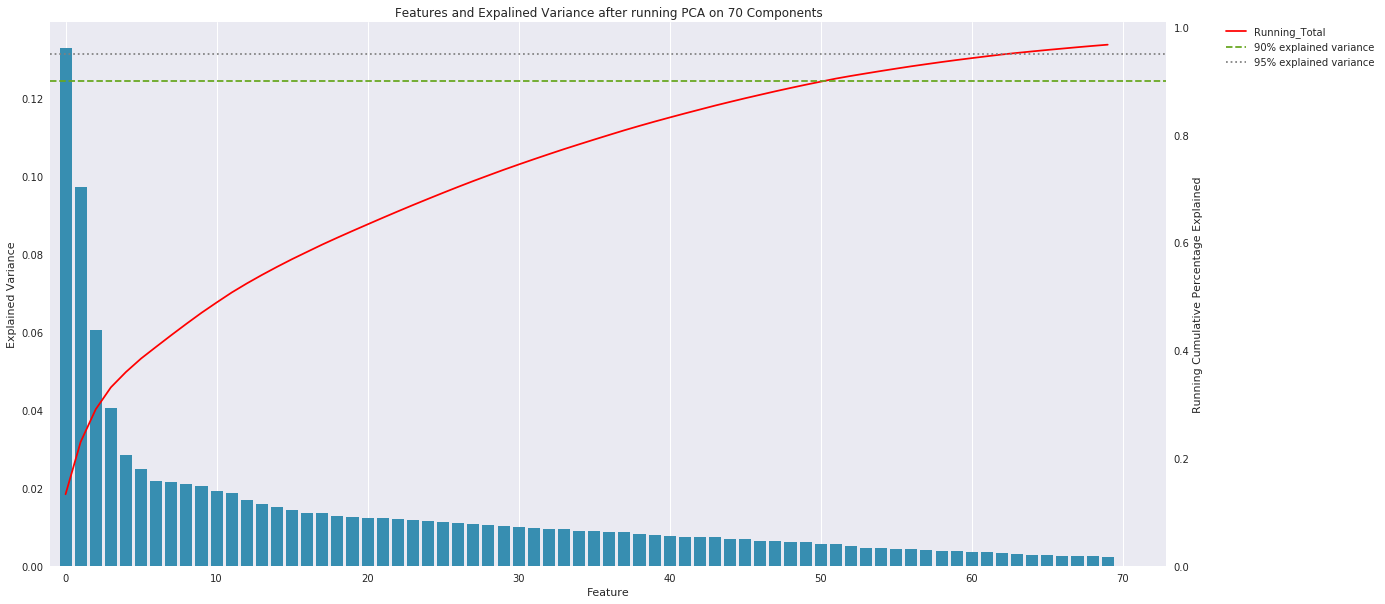

In [83]:
# Investigate the variance accounted for by each principal component.

# Plotting the data
fig, ax_1 = plt.subplots(figsize=(20,10))

ax_1.bar(var_df.index, var_df['Explained_Variance'], color='#378EB1')
ax_1.set_xlim(left= -1)
ax_1.yaxis.grid(False)
ax_1.xaxis.grid(True)
ax_1.set_ylabel('Explained Variance')
ax_1.set_xlabel('Feature')

ax_2 = ax_1.twinx()
ax_2.plot(var_df['Running_Total'], color='r')
ax_2.set_ylim(bottom= 0)
ax_2.set_ylabel('Running Cumulative Percentage Explained')

plt.axhline(y=0.9, color='C4', linestyle='dashed', label='90% explained variance')
plt.axhline(y=0.95, color='grey', linestyle='dotted', label='95% explained variance')
plt.title('Features and Expalined Variance after running PCA on 70 Components')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

### Discussion 2.2: Perform Dimensionality Reduction

While I initially looked at 70 principle components, with 50 I will be able to retain 90% of the explained variance in the dataset, and so I will move forward with these 50.

I could also have taken around 62 for an additional 5% variance, however I don't feel that that adding another 12 features for only a 5% gain is needed.

In [84]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(50) 
X_pca = pca.fit_transform(X)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [85]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Creating new dataframe of the original features versus the new components
_ = pd.DataFrame(pca.components_, columns=df.columns)
ratios = pd.Series(data=pca.explained_variance_ratio_, name='Explained_Variance')

princ_comp_df = pd.concat([ratios,_], axis=1)

In [86]:
princ_comp_df.head(3)

,Explained_Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,WOHNDAUER_2008,ANZ_HH_TITEL,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1,CJT_GESAMTTYP_2,CJT_GESAMTTYP_3,CJT_GESAMTTYP_4,CJT_GESAMTTYP_5,LP_FAMILIE_GROB_1,LP_FAMILIE_GROB_2,LP_FAMILIE_GROB_3,LP_STATUS_GROB_1,LP_STATUS_GROB_2,LP_STATUS_GROB_3,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_6,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MAINSTREAM_PRAEGENDE_JUGENDJAHRE,WEALTH_1,WEALTH_2,WEALTH_3,WEALTH_4,WEALTH_5,LIFE_STAGE_1,LIFE_STAGE_2,LIFE_STAGE_3,LIFE_STAGE_4,LIFE_STAGE_5,WOHNLAGE_1,WOHNLAGE_2,WOHNLAGE_3,WOHNLAGE_4,DECADE_PRAEGENDE_JUGENDJAHRE_1940,DECADE_PRAEGENDE_JUGENDJAHRE_1950,DECADE_PRAEGENDE_JUGENDJAHRE_1960,DECADE_PRAEGENDE_JUGENDJAHRE_1970,DECADE_PRAEGENDE_JUGENDJAHRE_1980,DECADE_PRAEGENDE_JUGENDJAHRE_1990,ANZ_HAUSHALTE_AKTIV,KBA13_ANZAHL_PKW,W_KEIT_KIND_HH,KONSUMNAEHE
0,0.132770,-0.106423,0.005387,-0.196992,0.129207,-0.101640,0.063567,0.065058,0.142237,-0.064179,-0.109690,0.030752,-0.021279,0.035151,0.066605,0.091477,0.071028,-0.030082,-0.078378,-0.070383,0.061444,0.080945,0.007193,0.018507,0.033927,0.096946,0.084444,-0.001823,0.019455,-0.081549,-0.006721,0.185352,-0.059398,0.026542,-0.031580,-0.054115,-0.201286,0.009069,0.122000,0.133319,-0.191056,-0.102353,0.164333,-0.137465,-0.097256,0.047266,-0.214816,-0.038365,0.070167,-0.195141,0.128995,0.193988,0.187551,0.033411,-0.146147,0.126765,0.167905,0.114538,-0.019973,-0.053431,0.024949,0.025264,0.014178,0.081827,-0.030507,-0.064491,0.200295,-0.018918,-0.187958,-0.095964,0.078036,-0.033167,0.041989,-0.049460,-0.087431,-0.068772,-0.080120,-0.015639,-0.003811,0.033730,0.097280,0.118457,0.109690,-0.103438,-0.113062,-0.011864,0.033723,0.158355,0.147023,-0.029708,-0.053024,-0.070699,-0.025593,-0.028290,0.032187,0.106044,-0.122908,-0.019026,-0.037492,-0.051925,-0.024380,0.014679,0.083592,0.119322,-0.070218,0.035091,-0.140175
1,0.097167,0.241853,0.061510,0.072298,-0.224696,0.218626,-0.195810,-0.216405,0.099497,0.038491,-0.019305,-0.048806,0.161065,-0.081674,-0.151210,-0.236053,-0.135929,-0.043193,0.166434,0.204048,-0.188024,-0.167854,0.098574,0.044147,0.080928,-0.221492,-0.218202,-0.002502,0.023760,-0.067019,0.006082,0.044420,0.055321,0.024936,-0.024000,-0.027065,-0.071666,-0.005929,0.042096,0.056580,-0.076003,-0.046975,0.075233,-0.060451,-0.033840,0.006768,-0.077882,-0.165776,0.022008,-0.079618,0.054166,0.080628,0.076030,0.009758,-0.062498,0.059615,0.075206,0.055140,0.070857,0.109154,-0.034187,-0.059344,-0.058650,0.060865,0.036523,-0.089631,0.032945,-0.015315,-0.020523,-0.075628,-0.167094,0.215134,0.021077,-0.006039,-0.029547,-0.023739,-0.042782,-0.007777,0.010744,0.011397,0.046173,0.024078,0.019305,-0.028505,-0.051046,-0.005168,0.017176,0.055641,0.033285,-0.033871,-0.026006,-0.020232,0.034973,0.004122,0.020184,0.029397,-0.058099,0.064981,0.107070,0.118795,0.066116,-0.058358,-0.201948,0.050796,-0.031455,0.122553,-0.055928
2,0.060530,0.050673,-0.362726,0.148421,-0.078189,0.074897,-0.169020,-0.069427,-0.061266,0.020262,0.063135,-0.005629,0.101045,0.265359,0.261919,0.102114,0.069754,0.341598,0.051986,-0.188750,0.245928,-0.188838,-0.272088,-0.303432,-0.332445,-0.047809,-0.054740,-0.000269,0.015359,-0.001947,0.011067,-0.037480,0.028828,0.013168,-0.010418,-0.006781,-0.016527,-0.011882,0.001802,0.025274,-0.021254,-0.039952

In [87]:
# Defining a function for sorting by Principal Component or Cluster number inputted

def to_sort_PCA(dataframe, component_number, top_bottom=None, method='PCA'):
    """
    Function to return list of original features sorted descendingly according to their weight within the
    component number.
    Input:
        dataframe:              dataframe with PCA applied
        component_number:       if method='PCA': number between 0 and 50 corresponding to the principal components 
                                if method='Inverse_PCA': number corresponding to the predicted clusters (int)
        top_bottom (optional):  number to return top n and bottom n features for principal component selected (int)
        method (optional):      either 'PCA' or 'Inverse_PCA'. If 'Inverse_PCA' then will rank the inversely 
                                transformed dataframe (str)
    Output:
        Full dataframe of sorted features and weights
        Optionally returns concatenation of top n and bottom n features and weights
    """
    if method == 'PCA':
        my_df = dataframe[dataframe.columns[1:]].T
    if method == 'Inverse_PCA':
        my_df = dataframe[dataframe.columns].T
        
    series_sorted = pd.Series(my_df[component_number].sort_values(ascending=False))
    series_sorted = series_sorted.reset_index()
    
    if method == 'PCA':
        series_sorted.columns = ['Feature', 'Component_' + str(component_number)]
    if method == 'Inverse_PCA':
        series_sorted.columns = ['Feature', 'Cluster_' + str(component_number)]
        
    concat_fi = pd.concat([feat_info, Data_dict_import.get_extended_dictionary_def()], axis=0, sort=False)
    series_sorted = series_sorted.join(concat_fi[['Text']], on='Feature', how='left')
    
    if top_bottom is None:
        out = series_sorted
    else:
        out = pd.concat([series_sorted.head(top_bottom), series_sorted.tail(top_bottom)], axis=0)
    return out

In [88]:
# Looking at Component_0 - top and bottom 4 features

zeroeth_comp = to_sort_PCA(princ_comp_df, component_number=0, top_bottom=4)
zeroeth_comp

,Feature,Component_0,Text
0,LP_STATUS_GROB_1,0.200295,low-income earners (maps to 1-2 in fine scale)
1,PLZ8_ANTG3,0.193988,Number of 6-10 family houses in the PLZ8 region
2,PLZ8_ANTG4,0.187551,Number of 10+ family houses in the PLZ8 region
3,HH_EINKOMMEN_SCORE,0.185352,Estimated household net income
102,PLZ8_ANTG1,-0.195141,Number of 1-2 family houses in the PLZ8 region
103,FINANZ_MINIMALIST,-0.196992,Financial typology: low financial interest
104,KBA05_ANTG1,-0.201286,Number of 1-2 family houses in the microcell
105,MOBI_REGIO,-0.214816,Movement patterns


In [89]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

first_comp = to_sort_PCA(princ_comp_df,1,4)
first_comp

,Feature,Component_1,Text
0,ALTERSKATEGORIE_GROB,0.241853,Estimated age based on given name analysis
1,FINANZ_VORSORGER,0.218626,Financial typology: be prepared
2,ZABEOTYP_3,0.215134,Energy consumption typology: fair supplied
3,SEMIO_ERL,0.204048,Personality typology: event-oriented
102,SEMIO_TRADV,-0.218202,Personality typology: tradional-minded
103,SEMIO_PFLICHT,-0.221492,Personality typology: dutiful
104,FINANZ_SPARER,-0.224696,Financial typology: money-saver
105,SEMIO_REL,-0.236053,Personality typology: religious


In [90]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

second_comp = to_sort_PCA(princ_comp_df,2,4)
second_comp

,Feature,Component_2,Text
0,SEMIO_VERT,0.341598,Personality typology: dreamful
1,SEMIO_SOZ,0.265359,Personality typology: socially-minded
2,SEMIO_FAM,0.261919,Personality typology: family-minded
3,SEMIO_KULT,0.245928,Personality typology: cultural-minded
102,SEMIO_KRIT,-0.272088,Personality typology: critical-minded
103,SEMIO_DOM,-0.303432,Personality typology: dominant-minded
104,SEMIO_KAEM,-0.332445,Personality typology: combative attitude
105,ANREDE_KZ,-0.362726,Gender


In [91]:
third_comp = to_sort_PCA(princ_comp_df,3,4)
third_comp

,Feature,Component_3,Text
0,GREEN_AVANTGARDE,0.311066,Membership in environmental sustainability as ...
1,EWDICHTE,0.252914,Density of households per square kilometer
2,ORTSGR_KLS9,0.250677,Size of community
3,WEALTH_1,0.188573,Wealthy Households
102,BALLRAUM,-0.213961,Distance to nearest urban center
103,HH_EINKOMMEN_SCORE,-0.217433,Estimated household net income
104,WOHNLAGE_4,-0.229985,rural neighborhood
105,MAINSTREAM_PRAEGENDE_JUGENDJAHRE,-0.311066,1: Mainstream or 0: Avantgarde


### Discussion 2.3: Interpret Principal Components

**Component_0** appears to be positively associated with the lower income population. Low-income earners and people from areas with mass-housing have high postive weights within this component. Conversely people from areas with less mass-housing, and those with little movement have highly negative weights within the component.

**Component_1** appears to be positively associated with the general population utilising large quantities of their disposable incomes. This is because of high weights within both the unknown component of age, and being less financially prepared. Similarly they rate highly negative in terms of being money-savers, dutiful, and religious.

**Component_2** appears to be positively associated with a personality that is more collectivist, interested in social fairness, family-focussed and avoiding conflict. Component_2 is strongly negatively associated with the consumer's gender, so both males and females are equally represented within this component.

**Component_3** is positively associated with high income, city dwellers who were previously considered to be avantgarde. This is due to household density and wealth having strongly positive weights, while rural and low incomes have strongly negative weights.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [92]:
# Over a number of different cluster counts run k-means clustering on the data and compute 
# the average within-cluster distances.

In [93]:
# Running on a random sample of 10000 to reduce computation time

_ = np.random.choice(np.arange(X_pca.shape[0]), 10000) 
my_sample = X_pca[_]

In [94]:
# Score indicates the average with-cluster distances
Score = []
K = range(1, 20, 1)
for k in K:
    k_means = KMeans(n_clusters=k)
    k_means = k_means.fit(my_sample)
    Score.append(np.abs(k_means.score(my_sample)))

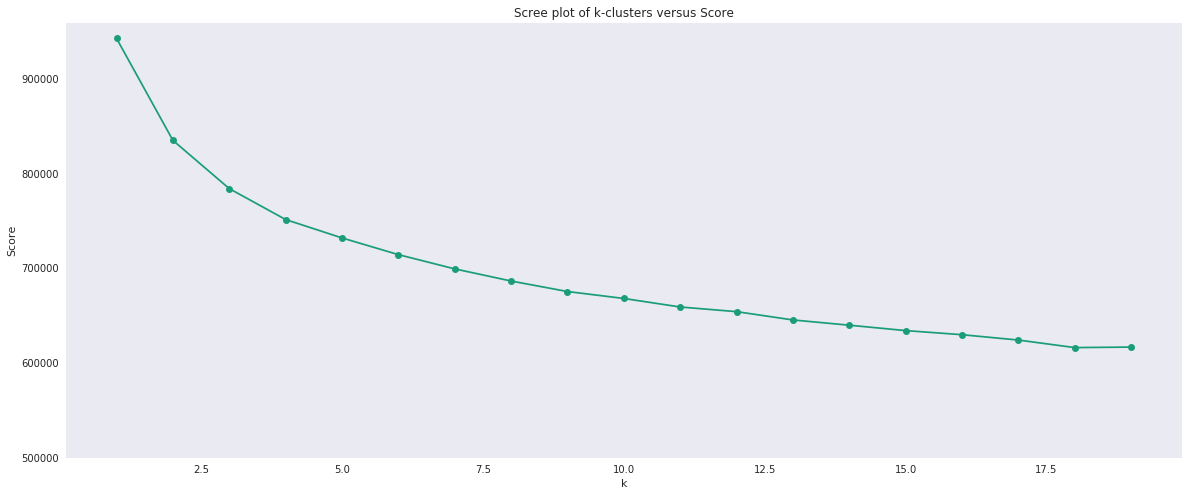

In [95]:
# Investigate the change in within-cluster distance across number of clusters.

plt.figure(figsize=(20,8))
plt.plot(K, Score, linestyle='-', marker='o')
plt.xlabel('k')
plt.ylabel('Score')
plt.ylim(500000)
plt.title('Scree plot of k-clusters versus Score');

From the above, using the 'elbow method' it looks like only 3 or 4 clusters is the optimal number of clusters.

In [96]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# Instantiating and fitting a model with 4 centers
gen_clf = KMeans(4)
gen_clf.fit(X_pca)

# Obtaining the cluster predictions
labels = gen_clf.predict(X_pca)

### Discussion 3.1: Apply Clustering to General Population

The population has been segmented into 3 clusters since the above scree plot/elbow method indicates that 3 is a good point, following which the decreases in score are less steep as further clusters are added.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [97]:
# Load in the customer demographics data.
customer_df = pd.read_csv('./Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [98]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers = clean_data(customer_df) #applying function for preprocessing, feature transformation
assert customers.shape[1] == df.shape[1]

In [99]:
# I imputed for Nulls in the columns 'ANZ_HAUSHALTE_AKTIV','KBA13_ANZAHL_PKW','W_KEIT_KIND_HH','KONSUMNAEHE'.
# Therefore if there are Nulls in any columns other than the above I need to drop those rows where the nulls exist.

my_list = customers.columns[customers.isna().any()].difference(['ANZ_HAUSHALTE_AKTIV','KBA13_ANZAHL_PKW',
                                                                'W_KEIT_KIND_HH','KONSUMNAEHE'])
print(my_list)

Index(['KBA05_GBZ'], dtype='object')


In [100]:
customers = customers.dropna(subset=my_list)

In [101]:
#Imputing with the mode
customers = create_imputed_values(['ANZ_HAUSHALTE_AKTIV','KBA13_ANZAHL_PKW'], "most_frequent", customers) 

#Imputing with the mean
customers = create_imputed_values(['W_KEIT_KIND_HH','KONSUMNAEHE'], "mean", customers) 

In [102]:
# Fit and transform cust_df
#cus_scaler = StandardScaler()
X_cust = gen_scaler.transform(customers)

# Creating 50 PCA components
X_pca_cust = pca.transform(X_cust)

# Instantiating and fitting the general population k-means model with 4 centers
cus_clf = gen_clf.fit(X_pca_cust)

In [103]:
# Obtaining the cluster predictions
cust_labels = cus_clf.predict(X_pca_cust)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [104]:
# Missing data will be shown as -1. The original 4 clusters are encoded 0-3.

# Appending the counts of the original general population data where there was more than 10 missing values per line
missing_data = np.repeat(-1,missing_gt_ten[0].shape[0])
labels = np.append(labels, missing_data)

In [105]:
# Counting null values per row and subsetting to more than 10 for customer data.
missing_cust = customer_df.isna().sum(axis=1).where(lambda x: x > 10).dropna()

# Appending count to the customer data
missing_data = np.repeat(-1,missing_cust.shape[0])
cust_labels = np.append(cust_labels, missing_data)

In [106]:
def proportion_dps(array):
    """
    Calculates the percentage count of each value for the inputted array
    """
    x_axis = set(array)
    my_list, idx = [], []
    for i in x_axis:
        my_list.append(np.count_nonzero(array == i))
        idx.append(i)
    my_perc = [num / array.shape[0] for num in my_list]
    ser = pd.Series(data=my_perc, index=idx)
    return ser

In [107]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

compare_df = pd.concat([proportion_dps(labels), proportion_dps(cust_labels)], axis=1)
compare_df.columns=['General_pop_perc', 'Cust_data_perc']

compare_df['Difference'] = compare_df['Cust_data_perc'] - compare_df['General_pop_perc']
compare_df = compare_df.sort_index()

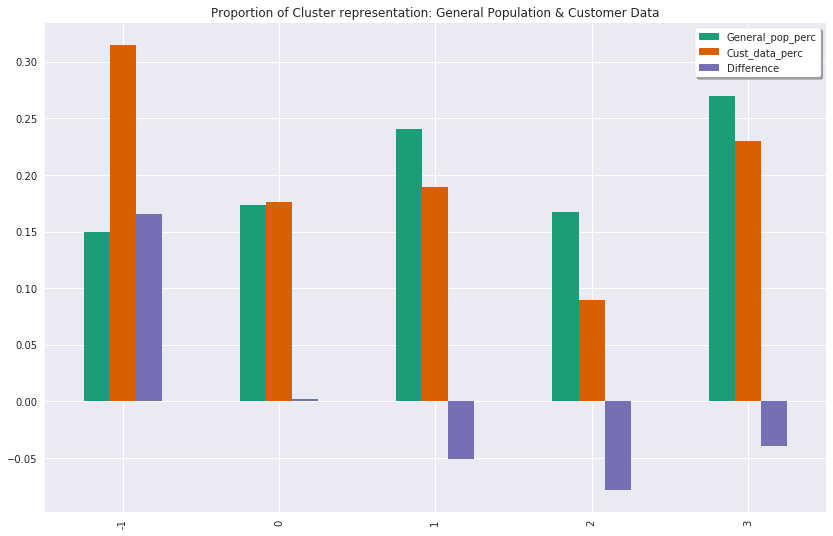

In [108]:
ax = compare_df.plot(kind='bar',figsize=(14,9), grid=True, 
                     title='Proportion of Cluster representation: General Population & Customer Data')
ax.legend(frameon=True, shadow=True, facecolor='white');

In [109]:
gen_specs = pd.DataFrame(gen_scaler.inverse_transform(pca.inverse_transform(gen_clf.cluster_centers_)), 
                             columns=df.columns)

cus_specs = pd.DataFrame(gen_scaler.inverse_transform(pca.inverse_transform(cus_clf.cluster_centers_)), 
                             columns=customers.columns)

gen_specs

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,WOHNDAUER_2008,ANZ_HH_TITEL,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1,CJT_GESAMTTYP_2,CJT_GESAMTTYP_3,CJT_GESAMTTYP_4,CJT_GESAMTTYP_5,LP_FAMILIE_GROB_1,LP_FAMILIE_GROB_2,LP_FAMILIE_GROB_3,LP_STATUS_GROB_1,LP_STATUS_GROB_2,LP_STATUS_GROB_3,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_6,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,MAINSTREAM_PRAEGENDE_JUGENDJAHRE,WEALTH_1,WEALTH_2,WEALTH_3,WEALTH_4,WEALTH_5,LIFE_STAGE_1,LIFE_STAGE_2,LIFE_STAGE_3,LIFE_STAGE_4,LIFE_STAGE_5,WOHNLAGE_1,WOHNLAGE_2,WOHNLAGE_3,WOHNLAGE_4,DECADE_PRAEGENDE_JUGENDJAHRE_1940,DECADE_PRAEGENDE_JUGENDJAHRE_1950,DECADE_PRAEGENDE_JUGENDJAHRE_1960,DECADE_PRAEGENDE_JUGENDJAHRE_1970,DECADE_PRAEGENDE_JUGENDJAHRE_1980,DECADE_PRAEGENDE_JUGENDJAHRE_1990,ANZ_HAUSHALTE_AKTIV,KBA13_ANZAHL_PKW,W_KEIT_KIND_HH,KONSUMNAEHE
0,3.502715,1.511470,3.048520,1.601500,4.600221,1.514211,1.709609,4.178290,0.920659,0.188182,2.002514,4.221128,4.171182,3.673946,2.827222,3.419184,4.405327,5.662398,5.371622,3.373817,2.937092,4.674096,4.514846,4.402733,2.942377,2.707829,0.010325,1.574548,1.751024,0.004904,5.025077,8.329887,0.138190,1992.215497,0.840182,0.687537,1.416886,0.999489,0.525583,2.370111,3.321836,5.002148,3.685573,3.404023,2.630657,2.079014,2.124205,4.658088,1.668112,3.368295,2.238663,1.099742,3.719930,2.906753,3.436301,6.603689,3.628945,0.210416,0.264191,0.119650,0.192147,0.213597,0.507399,0.201460,0.291141,0.523642,0.340452,0.135906,0.067177,0.183734,0.650029,0.099060,0.012182,0.015023,0.043752,0.037041,0.088708,0.223224,0.167219,0.279772,0.133079,0.811818,0.027204,0.080794,0.114763,0.406141,0.371097,0.410879,0.027164,0.107571,0.233377,0.221009,0.246825,0.413531,0.302762,0.036875,0.171663,0.312195,0.215213,0.161883,0.081854,0.057193,14.730944,560.054694,5.013977,2.136271
1,3.499379,1.366000,4.587018,1.442939,4.569866,2.088011,1.781358,2.333706,0.966260,0.204520,2.054418,3.617971,4.157013,3.749053,3.106992,2.953520,4.966143,5.390402,5.121981,3.911212,2.820583,3.976243,3.777075,3.418078,3.012546,2.800125,0.010380,1.475921,2.533938,0.000047,3.491418,8.785228,0.003499,1992.687740,0.950060,2.713018,1.045388,0.061191,0.004595,4.191260,5.486358,2.325944,6.098089,4.000012,2.874853,4.259207,3.140873,4.526852,3.021574,2.293988,0.774995,0.154187,3.391827,3.944866,2.229436,2.936815,2.025639,0.124629,0.359402,0.189909,0.138788,0.187272,0.207114,0.177763,0.615124,0.027634,0.099920,0.872445,0.387362,0.222160,0.386634,0.003844,0.011250,0.124963,0.239632,0.337386,0.085423,0.113709,0.050606,0.026901,0.010132,0.795480,0.136213,0.577017,0.096850,0.156566,0.033353,0.070269,0.212884,0.223257,0.348660,0.144931,0.088754,0.197706,0.100527,0.613015,0.088334,0.247683,0.273369,0.221776,0.106551,0.062288,1.742086,725.342264,3.933940,3.880646
2,3.470589,1.256624,4.806621,1.158063,4.676181,1.076746,1.938744,2.455632,0.970087,0.871679,1.822669,4.020710,4.766221,4.114888,3.168119,3.599007,5.647418,5.849302,4.607178,4.056109,2.775588,3.644645,3.829580,3.216156,2.777728,3.027375,0.008391,1.443782,2.546279,0.158698,2.023183,8.901576,0.193583,1992.375445,0.940465,2.797035,1.098264,0.032540,0.077855,3.973629,3.835761,4.210586,4.488618,4.010285,1.706970,4.130802,3.301432,2.751436,2.820134,2.623454,1.240196,0.429717,3.692930,3.873293,2.808647,5.451906,2.822510,0.153518,0.286

In [110]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
c_0 = to_sort_PCA(dataframe=cus_specs,component_number=0, top_bottom=10, method='Inverse_PCA')
c_0

,Feature,Cluster_0,Text
0,MIN_GEBAEUDEJAHR,1992.215497,First year building was mentioned in the database
1,KBA13_ANZAHL_PKW,560.054694,Number of cars in the PLZ8 region
2,ANZ_HAUSHALTE_AKTIV,14.730944,Number of households in the building
3,WOHNDAUER_2008,8.329887,Length of residence
4,ORTSGR_KLS9,6.603689,Size of community
5,SEMIO_LUST,5.662398,Personality typology: sensual-minded
6,SEMIO_ERL,5.371622,Personality typology: event-oriented
7,HH_EINKOMMEN_SCORE,5.025077,Estimated household net income
8,W_KEIT_KIND_HH,5.013977,Likelihood of children in household
9,EWDICHTE,5.002148,Density of households per square kilometer


The customer dataset is overrepresented for cluster 0, compared to the general population.
From the above profile, it can be said that people from cluster 0 are very likely to live in relatively older buildings, while also living in their homes for extended periods of time (7-10 years). They are also likely to live quite close to city centers.

Personality-wise, they rate high for being dreamful and event-orientated.

They also appear to be struggling financially, having a low financial interest level and definitely not forming part of the upper class. While a low number hold academic tertiary qualifications, they are also unlikely to be making use of a home-office setup.

In [111]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

g_2 = to_sort_PCA(dataframe=gen_specs,component_number=2, top_bottom=10, method='Inverse_PCA')
g_2

,Feature,Cluster_2,Text
0,MIN_GEBAEUDEJAHR,1992.375445,First year building was mentioned in the database
1,KBA13_ANZAHL_PKW,681.557276,Number of cars in the PLZ8 region
2,WOHNDAUER_2008,8.901576,Length of residence
3,SEMIO_LUST,5.849302,Personality typology: sensual-minded
4,SEMIO_VERT,5.647418,Personality typology: dreamful
5,ORTSGR_KLS9,5.451906,Size of community
6,FINANZ_MINIMALIST,4.806621,Financial typology: low financial interest
7,SEMIO_SOZ,4.766221,Personality typology: socially-minded
8,FINANZ_VORSORGER,4.676181,Financial typology: be prepared
9,SEMIO_ERL,4.607178,Personality typology: event-oriented


The customer population dataset is underrepresented for cluster 2, compared to the general population. From the above profile, it can be said that people from cluster 2 are again likely to live in older housing, residing around 6-7 years there. Communities are mid-sized.

Financial status appears to be the main distinguishing feature of this cluster relative to others - as people from this cluster are strongly negatively associated with being being low to average earners, it can be inferred that they are of a higher financial status and have more disposible income available to them. 

### Discussion 3.3: Compare Customer Data to Demographics Data

We can identify clusters that have over and under-representation relative the general population. Examples of these were cluster 0, which was over-represented and discussed above. Similarly cluster 2 was under-represented and also profiled above.

Cluster 3 was also under-represented relative to the population, although this was not to the same extreme as cluster 2. 

We can confirm that our customer base is heavily centered on cluster 0. Clusters 2 in particular might represent an opportunity if we wanted to change our business strategy and focus - this would depend on whether we'd want to get additional business from our customer base/cluster 0 (ie organic growth within cluster 0), or change focus and start targetting clusters 2. This might be a future consideration since members of cluster 0 appear to be far less financially affluent than those in cluster 2. Therefore the potential reward of targetting people within cluster 2 could be extremely appealing.

We can also compare the proportion of missing values. Within the customer dataset it shows that there was a definite issue with the proportion of missing data relative to the general population.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.